# Ultrametric Distance (Permutation Robust): Patient Comparison

Compute permutation-robust ultrametric distances across phases for every patient, per EEG band.
Plots show, for each band, permutation-robust distance matrices side-by-side for all PATIENTS_LIST.

In [ ]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc.notebook import *
# Figure output path
path_figs = Path('data') / 'figures' / 'DSTCMP_permutation_robust'
path_figs.mkdir(parents=True, exist_ok=True)
#
correlation_protocol = dict(threshold=0, spectral_cleaning=False)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


In [2]:
# data loader
data_dict, int_label_map = load_data_dict()
print('✓ Data loaded')

✓ Data loaded


### Build Ultrametric and Linkage Structures per Patient, Phase, Band

In [ ]:
ultra_by_pat = {}
linkage_by_pat = {}
condensed_by_pat = {}
for pat in PATIENTS_LIST:
    print(f'Computing ultrametric structures for {pat} ...')
    U, Z, D = compute_structures_for_patient(data_dict, pat, int_label_map)
    ultra_by_pat[pat] = U
    linkage_by_pat[pat] = Z
    condensed_by_pat[pat] = D
print('✓ Ultrametric structures computed for all PATIENTS_LIST')

Computing ultrametric structures for Pat_03 ...


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0068 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0078 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0098 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


Computing ultrametric structures for Pat_02 ...


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


✓ Ultrametric structures computed for all PATIENTS_LIST


## Phase Distance Matrices per Patient, Band

In [10]:
metric = 'euclidean'
results = {band: {} for band in BRAIN_BANDS_NAMES}
n = len(PHASE_LABELS)

for band in BRAIN_BANDS_NAMES:
    for pat in PATIENTS_LIST:
        dm = np.full((n, n), np.nan, dtype=float)
        pin_labels = int_label_map[pat]['label']
        for i, pi in enumerate(PHASE_LABELS):
            for j, pj in enumerate(PHASE_LABELS):
                if i == j:
                    dm[i, j] = 0.0
                    continue
                Z1 = linkage_by_pat[pat][band].get(pi)
                Z2 = linkage_by_pat[pat][band].get(pj)
                D1 = condensed_by_pat[pat][band].get(pi)
                D2 = condensed_by_pat[pat][band].get(pj)
                if Z1 is None or Z2 is None or D1 is None or D2 is None:
                    print(f'Warning: Missing data for {pat} in band {band}, phases {pi}, {pj}. Setting distance to NaN.')
                    dm[i, j] = np.nan
                else:
                    dm[i, j] = ultrametric_distance_permutation_robust(Z1, Z2, D1, D2, pin_labels, metric=metric)
        results[band][pat] = dm
    print(f'Band {band}: ✓ done')

print('✓ All phase-distance matrices computed')


Band delta: ✓ done
Band theta: ✓ done
Band alpha: ✓ done
Band beta: ✓ done
Band low_gamma: ✓ done
Band high_gamma: ✓ done
✓ All phase-distance matrices computed


## Plot: Side-by-Side Patients per Band

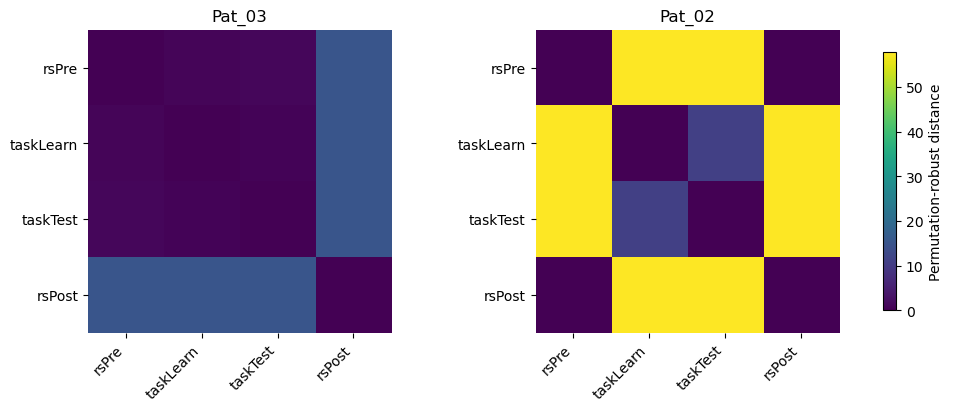

Saved: data/figures/DSTCMP_permutation_robust/delta/permutation_robust.png


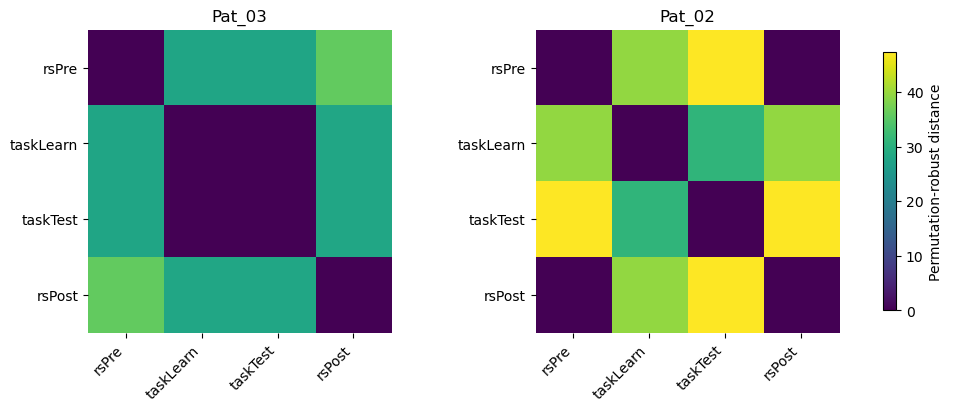

Saved: data/figures/DSTCMP_permutation_robust/theta/permutation_robust.png


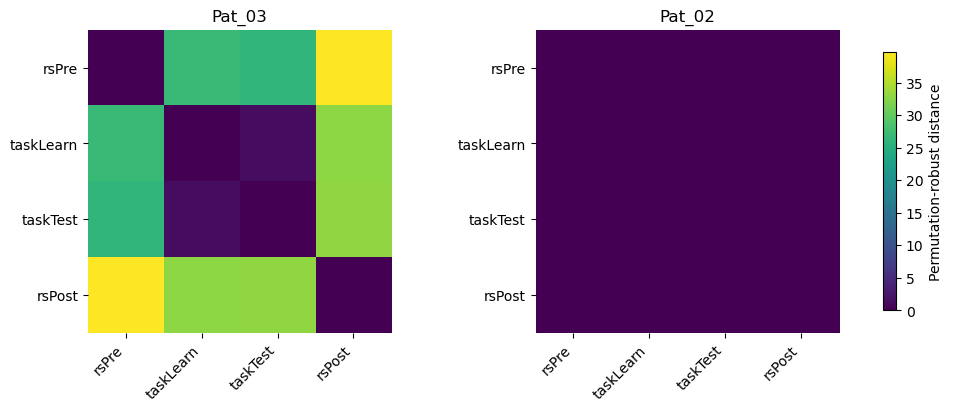

Saved: data/figures/DSTCMP_permutation_robust/alpha/permutation_robust.png


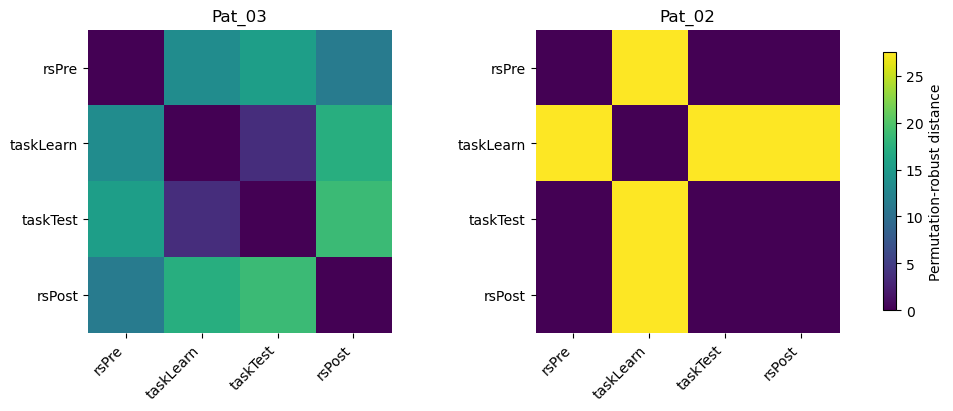

Saved: data/figures/DSTCMP_permutation_robust/beta/permutation_robust.png


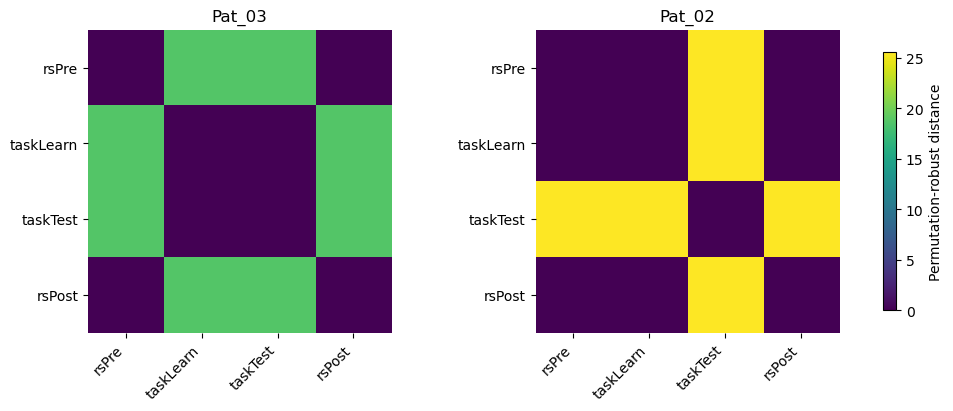

Saved: data/figures/DSTCMP_permutation_robust/low_gamma/permutation_robust.png


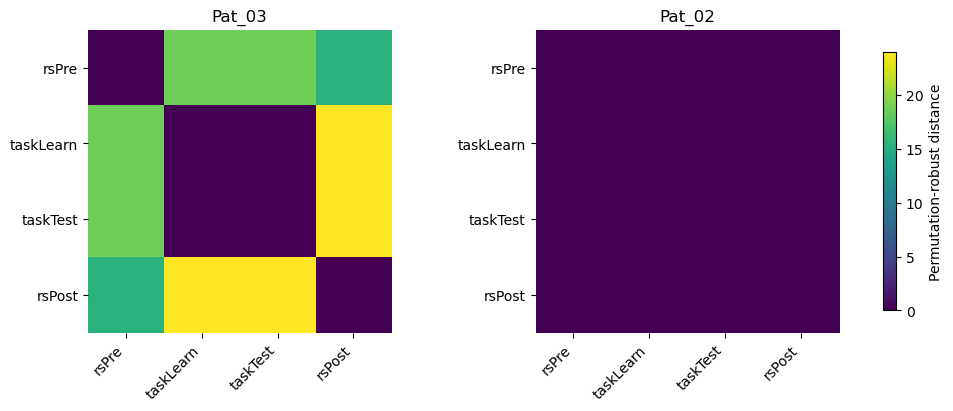

Saved: data/figures/DSTCMP_permutation_robust/high_gamma/permutation_robust.png
✓ All figures generated


In [11]:
def plot_band_side_by_side_permutation(band: str):
    vmax = 0.0
    for pat in PATIENTS_LIST:
        m = results[band].get(pat)
        if m is not None and np.isfinite(m).any():
            vmax = max(vmax, np.nanmax(m))
    if vmax == 0.0:
        print(f'[SKIP] No finite values for {band}')
        return

    fig, axes = plt.subplots(1, len(PATIENTS_LIST), figsize=(4*len(PATIENTS_LIST)+2, 4), constrained_layout=True)
    if len(PATIENTS_LIST) == 1:
        axes = [axes]

    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='lightgray')

    for ax, pat in zip(axes, PATIENTS_LIST):
        M = results[band][pat]
        im = ax.imshow(M, vmin=0.0, vmax=vmax, cmap=cmap, aspect='equal')
        ax.set_title(f"{pat}")
        ax.set_xticks(range(len(PHASE_LABELS)))
        ax.set_yticks(range(len(PHASE_LABELS)))
        ax.set_xticklabels(PHASE_LABELS, rotation=45, ha='right')
        ax.set_yticklabels(PHASE_LABELS)
        for spine in ax.spines.values():
            spine.set_visible(False)

    cbar = fig.colorbar(im, ax=axes, shrink=0.85)
    cbar.set_label('Permutation-robust distance')
    outdir = path_figs / band
    outdir.mkdir(parents=True, exist_ok=True)
    outfile = outdir / 'permutation_robust.png'
    fig.savefig(outfile, dpi=200, bbox_inches='tight')
    plt.show()
    print(f'Saved: {outfile}')

for band in BRAIN_BANDS_NAMES:
    plot_band_side_by_side_permutation(band)

print('✓ All figures generated')
